In [2]:
import pandas as pd
import numpy as np
import os
filedir = "."


prods = pd.read_csv(filedir + "/prods.csv")
actions = pd.read_csv(filedir + "/actions.csv")
buyers = pd.read_csv(filedir + "/buyers.csv")
prods_scraped = pd.read_csv(filedir + "/prods_scraped.csv")



def nan_1_and_0(df, only_value):
    df.loc[df == only_value] = 1
    df.fillna(0)


prods.columns = ["id1", "id2", "id3", "create_date", "description", "deleted", "deleteddate", "product_name", "id4", "id5", "name", "picture", "surl", "updated_date", "deleted_date", "category"]

for unused_col in ["deleteddate", "surl"]:
    del prods[unused_col]


prods = prods.drop_duplicates()


### Actions
for col in actions.columns:
    if actions[col].dtype == np.object:
        unique = actions[col].describe()["unique"]
        if unique == 1:
            top = actions[col].describe()["top"]
            nan_1_and_0(actions[col], top)

actions["context_product"] = actions["context_page_path"].str.split("/").str[-1]
actions.rename(columns={"id": "actions_id"}, inplace = True)

### Modify
products_missing_from_prods = list(set(actions["context_product"].values) - set(prods["name"].values))

products_missing_df = pd.DataFrame(products_missing_from_prods, columns=["name"])
prods = prods.append(products_missing_df).reset_index(drop=True)
prods = prods.drop_duplicates()


prods2 = prods.groupby(["name"]).agg({
    "category": {
        "joined_category": lambda x: " ".join([y if isinstance(y, str) else str(y) for y in x ]),
        "count": lambda x: len(x)
    },
    "id1": {"no_of_rows": "count"},
    "picture": {"picture": "first"},
    "description": {"description": "first"},
    "product_name": {"product_name": "first"},
}).reset_index()
prods2.columns = ["name"] + list(prods2.columns.droplevel(0)[1:])
prods2 = pd.concat([prods2, prods_scraped]).reset_index(drop=True)

del prods["category"]

positive_actions = ["Liked Product", "Added Product To List", "Followed User", "Followed Brand", "Followed List", "saved product"]

actions2 = actions.groupby(["user_id", "context_product"]).agg({
    "action": {
        "positive_action_count": lambda x: len([y for y in x if y in positive_actions])
        }
    }).reset_index()
actions2.columns = ["user_id", "context_product"] + list(actions2.columns.droplevel(0)[2:])



buyers2 = buyers.groupby(["owner"]).nunique()
del buyers2["owner"]
buyers2 = buyers2.reset_index()

product_name_nulls = prods2.loc[prods2["picture"].isnull(), "name"].values

prods2 = prods2[prods2["picture"].notnull()]



actions2 = actions2.merge(prods2, left_on="context_product", right_on="name")[actions2.columns]


buyers3 = buyers.groupby(["owner"]).agg({
    "_id": {"_id": "count"},
    "description": {"description": "first"},
    "name": {"name": "first"}
}).reset_index()
buyers3.columns = ["owner"] + list(buyers3.columns.droplevel(0)[1:])

buyers2 = buyers3[["owner", "_id", "description", "name"]].merge(buyers2[["owner", "description", "value"]], on="owner")
del buyers3
buyers2.columns = ["owner", "no_of_rows", "description", "name", "no_of_products", "no_of_categories"]



df = actions2.merge(buyers2, left_on="user_id", right_on="owner", how="left").merge(prods2, left_on="context_product", right_on="name", how="left")




/usr/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (5,14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (28,30,33,39,41) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/joeyism/.local/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/home/joeyism/.local/lib/python3.6/site-packages/pandas/core/groupby.py:4189: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version

In [3]:
def action_timeline(user_id, product):
    return actions.loc[(actions["user_id"] == user_id) & (actions["context_product"] == product), ["user_id", "context_product", "action"]]

In [5]:
actions_per_user = actions2[["user_id", "positive_action_count"]].groupby("user_id").sum().reset_index() #55.335 actions
actions_per_product = actions2[["context_product", "positive_action_count"]].groupby("context_product").sum().reset_index()

In [6]:
def histogram(arr, xlabel="", ylabel="", title=""):
    from matplotlib import pyplot as plt
    import matplotlib.mlab as mlab

    n, bins, patches = plt.hist(arr, 50, facecolor='g', alpha=0.75)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)

    plt.show()

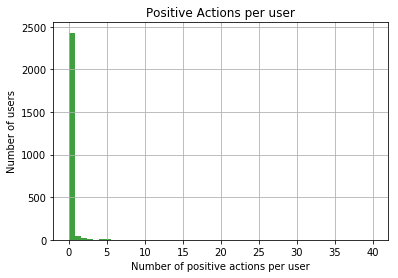

positive_action_count    0.157312
dtype: float64

In [14]:
histogram(actions_per_user["positive_action_count"].values, xlabel="Number of positive actions per buyers.csv", ylabel="Number of users", title="Positive Actions per user")
np.mean(actions_per_user)

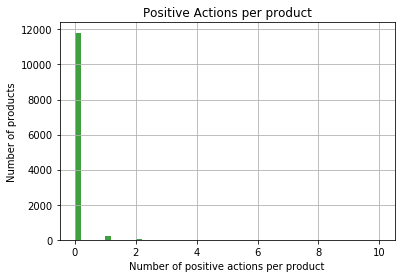

positive_action_count    0.032936
dtype: float64

In [13]:
histogram(actions_per_product["positive_action_count"].values, xlabel="Number of positive actions per product", ylabel="Number of products", title="Positive Actions per product")
np.mean(actions_per_product)

Most active users (top ~1%)

In [10]:
actions_per_user.loc[actions_per_user["positive_action_count"] > 5, "user_id"].values

array(['53ff5739aebb450829000074', '56390cf47023591c04001fcc',
       '5714ee12077a0f2b3edc8724', '571d8a1f01f843c233bdf218',
       '5745e9b0786dc7f65ceed1be', '57866f9691e1589d1758bf33',
       '57c745121ecce5bf1fd6d3be', '57c76886060960b5401076fd',
       '57dc360af351301060ed325b', '57e0283ca0d7207618260ed2',
       '57e58d5da642941f3aa57c16', '57e58d78a642941f3aa5838d',
       '58013f62d75b4cec48bde14b', '58146db51bf9803f3120c7d7',
       '58263010ae6f91ed77686f2d', '587eda2647619939bd9ba401',
       '592cdde4a2fff4117c20f33d', '59417523684f0f666f0525b3',
       '59640a21a3da9e329376f499'], dtype=object)

Most active products (top ~1%)

In [12]:
actions_per_product.loc[actions_per_product["positive_action_count"] > 2, "context_product"].values

array(['all-beauty-water-all-beauty-skincare-drink-cucumber-aloe',
       'arogyam-pure-herbs-arogyam-pure-herbs-face-care-kit',
       'aromaid-balanced-health-plus-aromaid-soothe-queasiness',
       'canine-royalty-mauve-and-ivory-100-cashmere-knit-sweater',
       'donkey-products-wall-hook-and-decal-hookly-captain-skull',
       'einstein-pets-pumpkin-time', 'gobare-crisps',
       'healthy-dogma-healthy-dogma-petmix-original-2-pound',
       'henschel-hats-1161_21-outback', 'hownd-playful-pup-body-mist',
       'jolieve-cocoa-and-truffle-gift-set', 'jon-wye-polka-dots-1',
       'klymit-hammock-v',
       'liquid-health-liquid-health-clear-skin-b5-acne-skin-care-supplement',
       'motoped-motopedr-survival',
       'prescribed-for-life-uva-ursi-20-arbutin-natural-leaf-extract-powder-arctostaphylos-uva-ursi-5-lb',
       'sadhana-clothing-colorful-chakras-legging',
       'sugarloom-cosmetics-nail-color-frost',
       'tash-cosmetics-black-out-charcoal-face-mask-withdmae',
      